In [94]:
import pandas as pd
import numpy as np
import copy
from random import random
import time
from time import sleep
import progressbar

In [95]:
print('************************************************')
print('*** WELCOME TO AUTO-AI CLASSIFICATION TOOL***')
print('************************************************')

**********************************************
*** WELCOME TO AUTO AI CLASSIFICATION TOOL***
**********************************************


In [96]:
def prog_bar():
        bar = progressbar.ProgressBar(maxval=20, 
                                      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
        bar.start()
        time.sleep(5)
        for i in range(20):
            bar.update(i+1)
            sleep(0.1)
        bar.finish()

In [97]:
def plot_auc(ytest, preds):
    fpr, tpr, threshold = roc_curve(ytest, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [98]:
path_train = input('Please provide the train data path: \n')
try:
    train = pd.read_csv(path_train)
except:
    print('Please provide a valid path and run again: \n')
    pass

Please provide the train data path: 
 F:\D\Practice\adult\adult_train.csv


In [99]:
path_test = input("Provide the test data path... if test data is not available type 'NA' to use cross validation on train data: \n")
if path_test == 'NA': 
                  test = train.iloc[int(len(train)*0.7):, :]
                  train = train.iloc[:int(len(train)*0.7):]
else:
                  try:
                      test = pd.read_csv(path_test)
                  except:
                        print('Please provide a valid path and run again')
                        pass

Provide the test data path... if test data is not available type 'NA' to use cross validation on train data: 
 NA


In [100]:
class pre_processing:
    def __init__(self, df_train, df_test, outcome):
        self.train = df_train
        self.test = df_test
        self.outcome = outcome
    def encode(self, how = 'label'):
        prog_bar()
        print('-- Initialising categorical columns encoding--\n')
        
      #  time.sleep(5)
        cat_cols = set(self.train.columns) - set(self.train._get_numeric_data().columns)
        cat_cols = list(cat_cols -{self.outcome})
        
        for col in cat_cols:
         
            self.train[col] = self.train[col].fillna('--null')
            train.shape
            freq = self.train[col].value_counts()
        
            if len(freq) > 5:
                list_ = list(self.train[col].value_counts().index)
                self.train[col] = self.train[col].apply(lambda x: x if x in list_ else 'remaining_ALL')
                self.test[col] = self.test[col].apply(lambda x: x if x in list_ else 'remaining_ALL')
        
                
        if how == 'label':
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            for col in cat_cols:
                self.train[col] = le.fit_transform(self.train[col].astype(str))
                self.test[col] = le.transform(self.test[col].astype(str))
            
        if how == 'ohe':
 
            X_train = pd.get_dummies(self.train[cat_cols], prefix = None, prefix_sep = '--', dummy_na = False, drop_first = True)
            X_test = pd.get_dummies(self.test[cat_cols], prefix = None, prefix_sep = '--', dummy_na = False, drop_first = True)
            

            no_cols = set(X_train.columns) - set(X_test.columns)
            for col in no_cols:
                X_test[col] = np.zeros(X_test.shape[0])
            X_test = X_test[X_train.columns]
            
            self.train.drop(cat_cols, axis=1, inplace=True)
            self.test.drop(cat_cols, axis=1, inplace=True)

            self.train = pd.concat([self.train, X_train], axis = 1)
            self.test = pd.concat([self.test, X_test], axis = 1)
        print('columns encoded: ')
        for cat in cat_cols:
            print(cat)
        
        print('-- Categorical columns encoding completed with {} encoding --'.format(how))
    def treat_missing(self, how = 'add_col'):
        prog_bar()
        print('-- Initialising NULL values imputation --\n')
        
  #      time.sleep(5)
        if how == 'add_col':
            null_num = self.train.isna().sum()
            null_list = list(null_num[null_num > 0].index)

            for col in null_list:
                self.train[col + '--null'] = np.where(self.train[col].isna(), 1, 0)
                self.test[col + '--null'] = np.where(self.test[col].isna(), 1, 0)
            self.train.fillna(0, inplace = True)
            self.test.fillna(0, inplace = True)
        print('-- Missing values imputed with {} imputation --'.format(how))
    def standardization(self, how = 'quantile', dump_data = 'yes'):
        prog_bar()
        outcome_1 = self.train[self.outcome].value_counts().index[1]
        outcome_0 = self.train[self.outcome].value_counts().index[0]
        
        train_Y = self.train[self.outcome].apply(lambda x: 1 if x==outcome_1 else 0)
        train_X = self.train.drop(self.outcome, axis = 1)

        test_Y = self.test[self.outcome].apply(lambda x: 1 if x==outcome_1 else 0)
        test_X = self.test.drop(self.outcome, axis = 1)
        
        if how == 'quantile':

            from sklearn.preprocessing import QuantileTransformer
            scaler = QuantileTransformer(n_quantiles = 1000)
            scaler.fit(train_X)
            train_X2 = pd.DataFrame(scaler.transform(train_X), columns = train_X.columns)
            test_X2 = pd.DataFrame(scaler.transform(test_X), columns = train_X.columns)


        if how == 'mean':
            train_X2 = (train_X - train_X.mean())/train.std()
            test_X2 = (test_X - test_X.mean())/test_X.std()

        if dump_data == 'yes':
            import pickle
            pickle.dump(train_X2, open('train_X.pkl', 'wb'), protocol = 4)
            pickle.dump(test_X2, open('test_X.pkl', 'wb'), protocol = 4)
            pickle.dump(train_Y, open('train_Y.pkl', 'wb'), protocol = 4)
            pickle.dump(train_X2, open('test_Y.pkl', 'wb'), protocol = 4)

        print('-- Standardization completed with {} normalization --'.format(how))
        return train_X2, train_Y, test_X2, test_Y



In [101]:
target = input('Please input the target column: \n')
c = pre_processing(train, test, target)

Please input the target column: 
 label


In [102]:
encoding = input('Categorical columns encoding: 1- label encoding, 2- OHE \n Entered value: ')
if encoding == '1':
    enc = 'label'
if encoding == '2':
    enc = 'ohe'
c.encode(how = enc)

Categorical columns encoding: 1- label encoding, 2- OHE 
 Entered value:  2


[========================================================================] 100%


-- Initialising categorical columns encoding--

columns encoded: 
workclass
native_country
education
sex
race
marital
relationship
occupation
-- Categorical columns encoding completed with ohe encoding --


In [103]:
treat_miss = input('Missing values Inpute: 1- add_col, 2- mean  \n Entered value: ')
if treat_miss == '1':
    enc = 'add_col'
if treat_miss == '2':
    enc = 'mean'
c.treat_missing(how = enc)

Missing values Inpute: 1- add_col, 2- mean  
 Entered value:  1


-- Initialising NULL values imputation --

-- Missing values imputed with add_col imputation --


In [104]:
treat_miss = input('Standardization: 1- mean, 2- quantile, 3- min-max  \n Entered value:')
dum_data = input('Do you want the dump of preprocessed data: ')
if treat_miss == '1':
    enc = 'mean'
if treat_miss == '2':
    enc = 'quantile'

train_X2, train_Y, test_X2, test_Y = c.standardization(how = enc, dump_data = dum_data)

Standardization: 1- mean, 2- quantile, 3- min-max  
 Entered value: 2
Do you want the dump of preprocessed data:  No


[========================================================================] 100%


-- Standardization completed with quantile normalization --


## Modeling

In [ ]:
print('------------------------------------------------------')
print('*** FITTING XGBOOST AND LOGISTIC REGRESSION MODELS **')
print('------------------------------------------------------')

In [72]:
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import scikitplot as skplt


#%matplotlib inline

In [73]:
def fit_model(model, train_X, train_Y, test_X, test_Y, grid, cv=5, n_jobs=20, score='roc_auc', feat_imp = 'ensemble'):
    random_search = RandomizedSearchCV(estimator = model(random_state=0), param_distributions=grid, 
                                       n_iter =sum(map(len, grid.values()))-5, cv=cv, verbose=5, n_jobs=n_jobs, scoring=score)
    random_search.fit(train_X2, train_Y)
    
    print('--best params--\n')
    print(random_search.best_params_)
    print('---------')
    
    print('--best_scores-- \n')
    print(random_search.best_score_)
    
    rfc_tuned = random_search.best_estimator_.fit(train_X, train_Y)
    xTrain_score = rfc_tuned.predict_proba(train_X)[:,1].astype('float64')
    xTest_score = rfc_tuned.predict_proba(test_X)[:,1].astype('float64')
    auc_xTrain = roc_auc_score(train_Y, xTrain_score)
    auc_xTest = roc_auc_score(test_Y, xTest_score)
    dataset = pd.DataFrame(['Train', 'Test'], columns = ['Dataset'])
    auc = pd.DataFrame([auc_xTrain, auc_xTest], columns = ['AUC'])
    gini = pd.DataFrame([2*auc_xTrain-1, 2*auc_xTest-1], columns = ['gini'])
    table = pd.concat([dataset, auc, gini], axis=1)
    
    if feat_imp == 'ensemble':
        var_imp = pd.DataFrame(dict(zip(train_X.columns, random_search.best_estimator_.feature_importances_))
                               .items()).sort_values(1, ascending=False)
    else:
        lr_imp = abs(random_search.best_estimator_.coef_[0])/abs(random_search.best_estimator_.coef_[0]).sum()
        var_imp = pd.DataFrame(dict(zip(train_X.columns, lr_imp)).items()).sort_values(1, ascending = False)
        
    var_imp.columns = ['Feature', 'Importance']
    
    plot_auc(train_Y, xTrain_score)
    plot_auc(test_Y, xTest_score)
    
    return table, var_imp


In [ ]:
print('-- Started Training XGBoost Model --')

In [58]:
xgb_grid = {'n_estimators': [int(x) for x in np.linspace(start=40, stop=300, num=20)],
            'eta':[ 0.01, 0.1, 1],
            'max_depth':[2,3,4]
            }

In [59]:
tab_xgb, imp_xgb = fit_model(XGBClassifier, train_X2, train_Y, test_X2, test_Y, xgb_grid, 
                             cv=5, n_jobs =50, score = 'roc_auc', feat_imp = 'ensemble')


Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done  17 out of 105 | elapsed:   54.7s remaining:  4.7min
[Parallel(n_jobs=50)]: Done  28 out of 105 | elapsed:  1.2min remaining:  3.4min
[Parallel(n_jobs=50)]: Done  39 out of 105 | elapsed:  1.5min remaining:  2.5min
[Parallel(n_jobs=50)]: Done  50 out of 105 | elapsed:  1.8min remaining:  2.0min
[Parallel(n_jobs=50)]: Done  61 out of 105 | elapsed:  1.9min remaining:  1.4min
[Parallel(n_jobs=50)]: Done  72 out of 105 | elapsed:  2.1min remaining:   58.0s
[Parallel(n_jobs=50)]: Done  83 out of 105 | elapsed:  2.3min remaining:   36.2s
[Parallel(n_jobs=50)]: Done  94 out of 105 | elapsed:  2.4min remaining:   16.8s
[Parallel(n_jobs=50)]: Done 105 out of 105 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=50)]: Done 105 out of 105 | elapsed:  2.6min finished


--best params--

{'n_estimators': 272, 'max_depth': 4, 'eta': 0.1}
---------
--best_scores-- 

0.9220067472860004


D:\anaconda\envs\tf_2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


IndexError: too many indices for array

In [38]:
print('XGBoost Performance')
print(tab_xgb)

XGBoost Performance
  Dataset       AUC      gini
0   Train  0.938635  0.877270
1    Test  0.927999  0.855998


In [40]:
print('XGBOost variable Importance')
print(imp_xgb)

XGBOost variable Importance
                                       Feature  Importance
76                 marital--Married-civ-spouse    0.391055
3                                education_num    0.078012
4                                 capital_gain    0.043671
95                  occupation--Prof-specialty    0.043075
89                 occupation--Exec-managerial    0.035075
..                                         ...         ...
43                 native_country--Philippines    0.000000
42                        native_country--Peru    0.000000
41  native_country--Outlying-US(Guam-USVI-etc)    0.000000
40                   native_country--Nicaragua    0.000000
99                occupation--Transport-moving    0.000000

[100 rows x 2 columns]


In [ ]:
print('-- Started Training Logistic Regression Model --')

In [67]:
lr_grid = {'penalty':['l2'],
           'C':[0.01, 0.1, 1, 10, 100],
          }

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=50)]: Done   3 out of   5 | elapsed:    1.3s remaining:    0.9s
[Parallel(n_jobs=50)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=50)]: Done   5 out of   5 | elapsed:    1.4s finished


--best params--

{'penalty': 'l2', 'C': 0.01}
---------
--best_scores-- 

0.8920989336320234


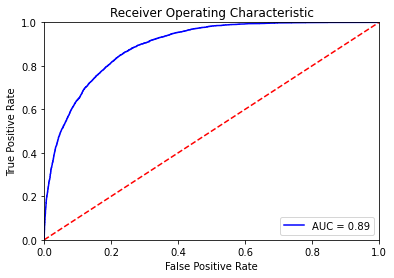

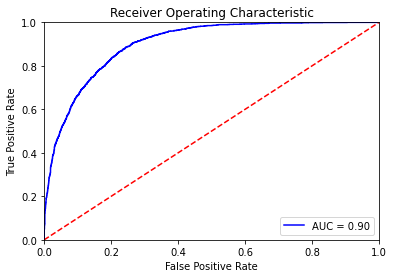

In [74]:
tab_lr, imp_lr = fit_model(LR, train_X2, train_Y, test_X2, test_Y, lr_grid, cv=5, n_jobs =50, score='roc_auc', feat_imp ='coeff')

In [43]:
print('Logistic Regression Performance')
print(tab_lr)

Logistic Regression Performance
  Dataset       AUC      gini
0   Train  0.894488  0.788977
1    Test  0.901541  0.803083


In [44]:
print('Logistic Regression Feature Importance')
(imp_lr)

Logistic Regression Feature Importance


,Feature,Importance
76,marital--Married-civ-spouse,0.073988
4,capital_gain,0.065174
3,education_num,0.064385
6,hours_week,0.052216
1,age,0.050719
...,...,...
51,native_country--Trinadad&Tobago,0.000116
88,occupation--Craft-repair,0.000102
45,native_country--Portugal,0.000053
9,workclass--Never-worked,0.000038


In [ ]:
model = XGBClassifier(n_estimators = 200, eta=0.1, max_depth=2)
model.fit(train_X2, train_Y)

imp_xgb_2 = pd.DataFrame(dict(zip(train_X2.columns, model.feature_importances_)).items()).sort_values(1, ascending =False)

In [ ]:
imp_xgb_2